# Spam classifier comparing Naive Bayes vs random forest (and playing around with sklearn pipelining)

Notebook looking at the UCI SMS Spam Collection data, using an NLP approach to build a spam detector based on Naive Bayes classifier.   

URL for dataset: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

## 1) Import libraries

In [73]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [74]:
import nltk # natural language toolkit

_nltk.download()_ gives you the downloader shell, from where we installed the 'stopwords' package.

## 2) Get data

In [75]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
#rstrip removes any ending spaces eg 'hello  ' -> 'hello'

## 3) Exploratory data analysis

In [76]:
print(len(messages))

5574


We can see we have 5572 df.  Let's have a look at the file in our text editor...

In [12]:
! subl smsspamcollection/SMSSpamCollection

Let's see what sort an object _messages_ is...

In [77]:
type(messages)

list

Let's  see what some of the dataset looks like, now we've read the file in...

In [78]:
for mess_no, message in enumerate(messages[:10]):
    print(mess_no, message, '\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... 

1 ham	Ok lar... Joking wif u oni... 

2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's 

3 ham	U dun say so early hor... U c already then say... 

4 ham	Nah I don't think he goes to usf, he lives around here though 

5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv 

6 ham	Even my brother is not like to speak with me. They treat me like aids patent. 

7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune 

8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

Let's have a look at a single line...

In [79]:
messages[50]

'ham\tWhat you thinked about me. First time you saw me in class.'

From the above, we can see that the file has its cols separated by tab i.e. \t.

It may be easier to work with this data using pandas rather than parsing text file with Python. Let's import the data again, this time as a pandas dataframe...

In [80]:
df = pd.read_csv('smsspamcollection/SMSSpamCollection', sep ='\t', names=['label','message'])

### Let's have another exploratory look at the data using our pandas tools...

In [81]:
df.columns

Index(['label', 'message'], dtype='object')

In [82]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [83]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's group the messages by their classification...

In [84]:
df.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

## 4) Feature engineering

Let's create a new feature: message length (num chars)

In [85]:
df['length']=df.message.apply(len)

In [86]:
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


With the above feature we can now more readily ask some more questions about our dataset:

How many characters are present in _all_ our msgs?

In [87]:
sum(df.length)

448490

What's the total number of words in _all_ our messages?

In [88]:
sum(df.message.str.split().apply(len))

86909

What's the average number of characters in a word?

In [89]:
sum(df.length)/sum(df.message.str.split().apply(len))

5.1604551887606576

What's the average number of characters in a message?

In [90]:
df.describe()

,length
count,5572.000000
mean,80.489950
std,59.942907
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,910.000000


Let's visualise the from our new feature...

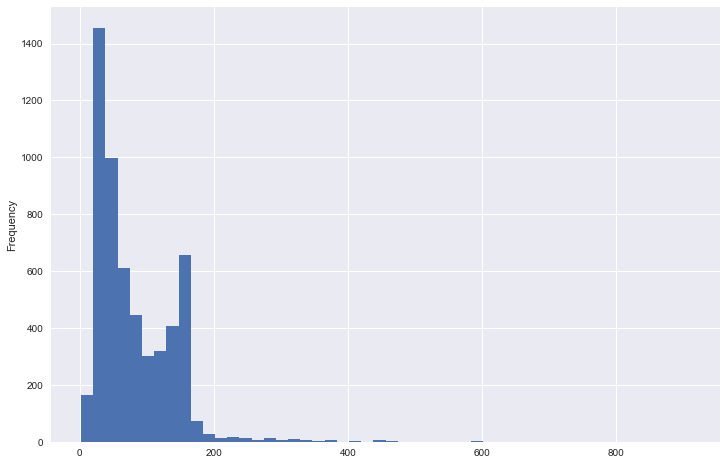

In [91]:
plt.figure(figsize=(12,8))
df.length.plot.hist(bins=50)

From the above plot, we can see what looks like it might be a bimodal distribution

The distribution also looks long-tailed - skewed to low frequncy higher length df.

Let's revisit df.describe() to get a handle on these long df.

In [92]:
df.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

** Let's find the long message **

In [93]:
df[df.length==910]  # simple pandas masking

,label,message,length
1085,ham,For me the love should start with attraction.i...,910


Let's get the full message...

In [94]:
df[df.length==910].iloc[0]['message']
# By explicitly referncing the message col we get full data rather than abridged.
# Note that "df[df.length==910]" is a df so we .iloc off that

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [95]:
# Alternatively provide the row number via .idxmax()
df.iloc[df.length.idxmax()]['message']

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Message length might be a helpful factor in distinguishing between ham and spam.
Let's compare distributions for our two labels...

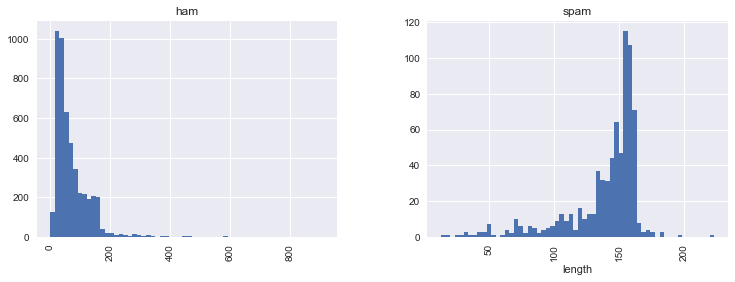

In [196]:
df.hist(column='length', by = 'label', bins = 60, figsize=(12,4))
plt.xlabel('length') 
# xlabel needs tweaking for pandas.hist when using by=

Whilst the scales are different, it does look like the mean message length values for 
spam are greater than ham.



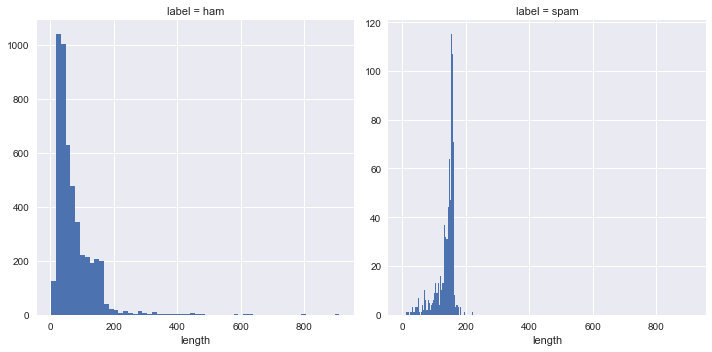

In [97]:
# Or alternatively creating same plot with seaborn using FacetGrid
# ..x axis scales correspond and x labelling works
g = sns.FacetGrid(df, col='label', size=5, sharey=False)
g.map(plt.hist, 'length' , bins=60)
#plt.tight_layout

## 5) Data preparation

#### Outline of approach:

#### i) Text preprocessing

Ultimately we need to convert strings to numerical features.  As a precursor to that we need to do some finessing of text items. This work considers for example, punctuation, case, and translating a message represented by a single string into a list of words. It's convenient to aggregate the work we do here in to a single function (this can then be called in the next step, by the method that converts the corpus to bag-of-words) 

#### ii) Entire corpus (all of the words in all the dataset messages) becomes a _bag-of-words_.  
Each unique word in the corpus is given a unique number. <br>

*bag\_of\_words\_dict* = {'green': 5, 'fastest': 302, 'and': 17, 'airplane': 0 }  <br>
*(NB Not in numerical order because dict)*

####  iii) Tokenise the messages (translate each message into a list which provide ID and freq count of each word present within that message)


Each message becomes a vector whereby each vector element corresponds to a feature (word_ID). We refer to the words represented in this way as *tokens*.
<br> 
<br> 
Example:  Message 13 becomes the vector [0, 0, 1, 0, 5, 0, 0, 0, 0, 0, 0,...,0]:

    0 in col 0 indicates bag_of_words word 0 is absent
    0 in col 1 indicates bag_of_words word 0 is absent
    1 in col 2 indicates bag_of_words word 2 is present once in message 13
    0 in col 3 indicates bag_of_words word 3 is absent        
    5 in col 4 indicates bag_of_words word 4 is present 5 times in message 13  
    
When a message becomes translated into a vector, word order is not preserved.  The vector only tells us about the words present and a count of how many times it is present.

#### iv) Term normalisation and weighting

Essentially this addresses the effect whereby more common words tend to carry less information that is able to help the algorithm classify.  So we need to de-weight words that occur frequently in our corpus.

Thinkabout it like this.  We find the word 'and' in our message several times.  If we scored words in a message based on the frequency of those words in the corpus, then the algorithm would simply identify messages with very common words in them.   We don't want the algorithm looking this up in the corpus and scoring a message containing  3 'and's highly on the basis of its frequency in the message.  

We now work through the 4 steps outlined above...

### i) Text preprocessing

#### The following illustrates how we'll remove punctuation...

In [98]:
import string #pandas library

In [99]:
# Remove puctuation
mess = "Look at this! - It's got punctuation."

In [100]:
string.punctuation # gives list of punctuation symbols

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [101]:
nopunc = [c for c in mess if c not in string.punctuation]
nopunc

['L',
 'o',
 'o',
 'k',
 ' ',
 'a',
 't',
 ' ',
 't',
 'h',
 'i',
 's',
 ' ',
 ' ',
 'I',
 't',
 's',
 ' ',
 'g',
 'o',
 't',
 ' ',
 'p',
 'u',
 'n',
 'c',
 't',
 'u',
 'a',
 't',
 'i',
 'o',
 'n']

In [102]:
nopunc=''.join(nopunc)
nopunc

'Look at this  Its got punctuation'

#### This is how we split our string into words...

In [103]:
from nltk.corpus import stopwords

In [104]:
stopwords.words('english') # Note to get the list of stopwords we need to do 2 things:
# i) we need to call the words method on stopwords
# ii) we need to pass in the argument specifying we want 'english' stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [105]:
nopunc

'Look at this  Its got punctuation'

In [106]:
nopunc.split() # .split() separates on space unless sep is set otherwise
# Note: Does not change object.  Returns list of the split components 

['Look', 'at', 'this', 'Its', 'got', 'punctuation']

In [107]:
nopunc # Note nopunc is not split!

'Look at this  Its got punctuation'

#### This is how we will remove common words (stopwords)

In [108]:
clean_message = [word for word in nopunc.split() 
              if word.lower() not in stopwords.words('english')]

In [109]:
clean_message

['Look', 'got', 'punctuation']

#### We now wrap the above into a function...

In [110]:
def process_text(message):
    """
    1. convert string to single chars
    2. remove punctuation marks
    3. rejoin chars with ''.join(list of chars) to create unpunctuated string
    2. split unpunctuated string into list of words (split on sep default=space)
    2. remove stopwords
    3. return list of remaining words
       
    A few instructive notes:
    - We assume import string has been executed
    
    - The list comprehension will act on each element of whatever sequence provided.  
    Thus if we supply a sequence that is a string, the list comp will iterate over individual chars
    We therefore need to supply a list of words - hence the use of .split().
    .split() converts a string to a list of strings (splitting on whatever sep delimiter is set to)   
    
    -''.join() uses whatever is in the quotes to join.  (So '>'.join(['a', 'b', 'c']) returns 'a>b>c') 
    
    """
   
    list_of_chars_no_punctuation = [char for char in message if char not in string.punctuation] 
    # breaks into single chars
    
    message_no_punc = ''.join(list_of_chars_no_punctuation) # rejoins so we get a single string
    #print(mess_no_p)
    
    return [word for word in message_no_punc.split() if word.lower() not in stopwords.words('english')]

Let's do a quick test of our function...

In [111]:
test_msg = 'Dave the big (black) dog: a sight for sore eyes!!'
process_text(test_msg)

['Dave', 'big', 'black', 'dog', 'sight', 'sore', 'eyes']

We can also broadcast the function across multiple messages in our dataset using _.apply()_...

In [112]:
df.message.head().apply(process_text) 

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### ii) Convert entire corpus to bag-of-words

First we import the vectoriser class.  This will be used to create a vectoriser object which will convert the corpus of messages to bag-of-words...

In [113]:
from sklearn.feature_extraction.text import CountVectorizer

Next we instantiate an object based on the CountVectorizer class and we supply our *process\_text()* function as an _analyzer_ with which the vectoriser can process the raw text strings...

In [114]:
bow_transformer = CountVectorizer(analyzer=process_text)

And then we fit the created vectoriser object to our corpus...

In [115]:
bow_transformer.fit(df.message)

CountVectorizer(analyzer=<function process_text at 0x7f0d42fd80d0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

Let's see what our generated dictionary for the entire corpus looks like using the object's *.vocabulary\_* attribute? 

In [123]:
print(bow_transformer.vocabulary_)

{'owed': 8678, 'DearMe': 1636, 'siguviri': 9776, '10K': 306, 'paypal': 8777, 'Balls': 1220, 'death': 5911, '07732584351': 29, 'politicians': 8923, 'tallent': 10308, 'saved': 9550, 'shrink': 9753, '40': 606, 'driver': 6169, 'Fails': 1892, 'WALES': 4196, 'SK3': 3496, 'corrupt': 5725, 'jog': 7520, 'fassyole': 6488, 'Valid': 4161, 'kz': 7664, 'Content': 1517, 'wwwcomuknet': 11230, 'fren': 6706, 'internal': 7397, 'aa': 4460, '42810': 622, 'dearslp': 5908, 'youdoing': 11320, 'cum': 5805, 'friends': 6719, 'GOSSIP': 2010, 'Dates': 1627, 'taxi': 10324, 'lazy': 7731, 'GANG': 1970, 'blog': 5080, '4WARD': 658, '24': 449, 'bedbut': 4974, 'ayo': 4879, 'dead': 5893, 'upgrade': 10764, 'GENT': 1979, 'brothas': 5192, 'cave': 5382, 'shoreThe': 9729, 'ibuprofens': 7280, 'mentionned': 8121, '86888': 866, 'age16': 4569, 'herwho': 7107, 'Credit': 1539, 'Wahleykkumsharing': 4255, 'responding': 9381, 'feng': 6528, 'mb': 8068, 'Box1146': 1293, 'Teacher': 3933, 'wan': 10942, 'Dat': 1625, 'Arms': 1088, 'trade': 1

Let's see how many words in total there are in the bag-of-words vocabulary we have created from our messages...

In [124]:
sum(df.message.str.split().apply(len))

86909

Let's see how many unique words are in the vocabulary that we have generated from our messages...

In [125]:
print(len(bow_transformer.vocabulary_))

11425


### iii) Tokenise the messages 

What we ultimately want is that each msg gets transformed to vector of word IDs (tokens) and counts.<br> 

Let's initially look at applying our trained transformer to a single message. Let's look at the 4th message (so index = 3).

In [126]:
message_4 = df['message'][3]

In [127]:
print(message_4)

U dun say so early hor... U c already then say...


Let's use our bag-of-words transformer to tokenise message 4...

In [128]:
bow4 = bow_transformer.transform([message_4])
bow4

<1x11425 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [129]:
print(bow4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


We can see from the above that there are 7 different (unique-within-this-message) words in message 4;

5 of them appear only once,

2 of them appear twice (4068 & 9554).

Let's look at the shape of this transformed message...

In [130]:
print(bow4.shape)

(1, 11425)


The token is 1 row (as we'd expect').

It has the same number of columns as there are words in the corpus.  It is thus a sparse mapping of the message with respect to the corpus. Most of the values will be zero, indicating that particular corpus word is not present in the message.  The number of positive valued elements will be small.  

Remember that the value of each elemnt can be 1 or more.  

The _index_ corresponds to the word from the corpus which is being referred to.  The _value_ at the index indicates the frequency of that word in the message.

Let's satisfy ourselves that our vector for our 4th message corresponds to the original message.
Here is the 4th message...

In [131]:
print(message_4)

U dun say so early hor... U c already then say...


Let's get the token values from our transformed message_4 and read the corresponding corpus words, using the transformer...

In [132]:
print(bow_transformer.get_feature_names()[4068])
print(bow_transformer.get_feature_names()[4629])
print(bow_transformer.get_feature_names()[5261])
print(bow_transformer.get_feature_names()[6204])
print(bow_transformer.get_feature_names()[6222])
print(bow_transformer.get_feature_names()[7186])
print(bow_transformer.get_feature_names()[9554])

U
already
c
dun
early
hor
say


These are as expected.  Let's now transform each and every message in our datset into tokens...

In [133]:
df_bow = bow_transformer.transform(df.message)

In [134]:
df_bow

<5572x11425 sparse matrix of type '<class 'numpy.int64'>'
	with 50548 stored elements in Compressed Sparse Row format>

We can get a better sense of what the above output means by looking at a single row

In [135]:
df_bow[3]

<1x11425 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

Each row is a sparse representation.  There are 11425 fields, one for each unique word in the corpus.  Our message has 9 words but only 7 unique hence the output above.  <br>

The preceding line, referring to the entire dataset contains 5572 rows, one for each message

So we have created what looks like an X matrix with rows = examples and col index = word_value

Let's recap what we have just done.

When we *fit* using CountVectorizer object (bow\_transformer) with our entire message corpus, we generate a dictionary (CountVectorizer.vocabulary\_) where keys are words and values are word ID numbers.  We thus create a bag-of-words model for our corpus.

When we *transform* using the CountVectorizer object (bow_transformer) we convert the messages into a sparse representation where indices refer to the word IDs in the bag-of-words and values at indices indicate frequency.  NB Word order is not preserved when the messages are tokenised to vector form. 

In transforming all our (text processed) messages, we effectively converted them into a matrix where row = message, col_index = word ID in bag-of-words dict and value at the index = freq of that word in the message. 

We thus have a (sparse) X matrix, where rows are examples and columns are features, so we are now back on familair machine learning territory!

Now let's quickly check the shape of our matrix and briefly consider how our data is distributed within it (sparsity).

In [136]:
print('Shape of sparse matrix: ', df_bow.shape)

Shape of sparse matrix:  (5572, 11425)


And what is the size of our matrix (how many locations or fields are there in it)?

In [137]:
size_matrix = df_bow.shape[0]*df_bow.shape[1]
size_matrix

63660100

And how many of those fields contain non zero elements?

In [138]:
df_bow.nnz #attribute not method

50548

How does this compare to the size of the matrix...

In [139]:
df_bow.nnz/size_matrix

0.0007940295412668218

The above result can be thought of as approxaimtely 1 in every thousand locations has a positive value 

Let's formally calculate the sparsity (and density) of our matrix...

In [140]:
density = (df_bow.nnz/size_matrix) 
sparsity = 1-density

print('Density of matrix = {:.2} or {:.2}%'.format(density, density*100))

print('Sparsity of matrix = {:.4f} or {:.1f}%'.format(sparsity, sparsity * 100))

Density of matrix = 0.00079 or 0.079%
Sparsity of matrix = 0.9992 or 99.9%


### iv) Term weighting and normalisation

So we have created what looks like an X matrix where rows = examples and col index represents a word (token) and the value represents that word's frequency.  Does this mean we have useful features with which to build a spam classifier?

Ultinately, we are building a spam classifier that will interpret word IDs and their frequencies in a message to decide if a message is spam or ham. If the  same word appears twice in a message, that could be tell you something...but this is only useful if it's a word that you wouldn't expect to appear twice.  If we saw multiple 'ands' in a message, that doesn't help us because 'and' naturally occurs in our language more than many other words do.

We can account for this by deweighting more common words.  How do we know if a word is common? It will be present more than other words in the corpus.  

How much should we de-weight a common term?  Well, the more common it is, the more we should de-weight it.

We can use _inverse document frequency_ (_idf_) to de-weight common terms:  $$idf = ln{\frac{n_d}{df}} ,$$

where $n_d$ is number of documents in corpus and $df$ is number of documents containing that term.


**An illustration:**

**Example 1**:

    Message_15 has 10 words in it, 2 of which are '_ands_'. The $tf$ = 2/10 = 0.2.
    The word _and_ occurs in 99 out of our 100 documents so $$idf = ln{\frac{100}{99}} = 0.01 .$$

    We multiply the 2 terms to get our tf-idf value 0.2 * 0.01 = 0.02
    We see that the small idf has _decreased_ the weight of this term.


**Example 2**:

    Message 16 has 10 words in it, 2 of which are '_eon_'.  The $tf$ = 2/10 = 0.2.
    The word _eon_ occurs in 1 out our 100 documents so $idf = ln{\frac{100}{1}} = 4.61$$

    We multiply the 2 terms to get our tf-idf value 0.2 * 4.61 = 0.92
    We see that the large idf has _increased_ the weight of the term.




Remember: idf is a meaure of *rarity* in the corpus.  Rare words have high idf values

Postscript: <br>There are variants of the basic idf equation.  It's not uncommon to add1 to the denominator to avoid division by zero. Scikit-learn also adds 1 to the numerator aswell.

**In summary then...**

1. Count how many times a word occurs in each message (tf),

2. Determine how many documents a word occurs in out of all documents (inverse document frequency),

3. For each word in message generate tf\*idf values

4. Normalize each message vector so terms sum to 1



Let's transform our *df\_bow* matrix, which currently holds word counts, into tf-idf values...

In [141]:
from sklearn.feature_extraction.text import TfidfTransformer 

In [142]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(df_bow) 

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [150]:
# Let's just look at a single message (message_4 again) to see what happens when we use our tfidf transformer
tfidf4 = tfidf_transformer.transform(bow4)
print(bow4)
print('\n')
print(tfidf4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


  (0, 9554)	0.538562626293
  (0, 7186)	0.438936565338
  (0, 6222)	0.318721689295
  (0, 6204)	0.299537997237
  (0, 5261)	0.297299574059
  (0, 4629)	0.266198019061
  (0, 4068)	0.408325899334


It's easy to see what our document frequencies are.  For example bow4 contains 9 words.  The last word ('say') appears twice.  Its tf therefore is 2/9.

But what about the idf values?  

Let's look up 'say' in our bow vocabulary... 

In [152]:
tfidf_transformer.idf_[bow_transformer.vocabulary_['say']]

5.2312396328970978

Let's manually calculate the tf-idf...

In [154]:
(tfidf_transformer.idf_[bow_transformer.vocabulary_['say']]+1) * 2/9

1.3847199184215773

The reason that this is not what we see above (0.4083) is because as a final step, the tfidftransformer carries out l2 normalisation.  

Each of the values needs to be divided by the square root of the sum of all the squared tfidf values in the message. 

What is the idf of the word 'university'?

In [161]:
tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

8.527076498901426

What is the idf of the word 'hi'?

In [159]:
tfidf_transformer.idf_[bow_transformer.vocabulary_['hi']]

6.5811663498461135

'hi' (6.581) is less rare than 'university' (8.527)

In [157]:
tfidf_transformer.idf_[bow_transformer.vocabulary_['pyridine']]

KeyError: 'pyridine'

And finally, let's transform the entire bag-of-words dataframe...

In [158]:
messages_tfidf = tfidf_transformer.transform(df_bow)

## 6) Build model

Let's use Naive Bayes Classifier - this is usually a good option for text data...

In [162]:
from sklearn.naive_bayes import MultinomialNB

In [163]:
X = messages_tfidf
y = df.label

In [164]:
spam_detect_model = MultinomialNB().fit(X, y) 
# Note we are training on entire dataset here !!!

Let's use our trained model do a single prediction on the message we transformed to tfidf earlier... 

In [165]:
spam_detect_model.predict(tfidf4)[0]

'ham'

Did we predict correctly?

In [166]:
df.iloc[3]['label']

'ham'

Note that whilst we were looking at one example above, we were predicting for data that the model had already been exposed to (i.e. trained on)

Let's go ahead now and split the data into train and test before we go any further.

In [169]:
from sklearn.model_selection import train_test_split

In [194]:
msg_train, msg_test, label_train, label_test = train_test_split(
    df.message, df.label, test_size=0.3)

So we've now created our separate train and test sets. Rather than rewriting/rerunning some of the above code on our newly created train set (before going on to make predictions on our test set), let's instead bundle the fit and transformation steps that we've previously defined above into a pipeline... 

In [171]:
from sklearn.pipeline import Pipeline

Create pipeline of our various transformers and a final estimator...

In [173]:
pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=process_text)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB())
    ])

In [174]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function process_text at 0x7f0d42fd80d0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=No...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [175]:
y_pred = pipeline.predict(msg_test)

In [176]:
from sklearn.metrics import classification_report, confusion_matrix

In [177]:
print(confusion_matrix(label_test,y_pred))

[[1443    0]
 [  72  157]]


From the confusion matrix we see:
    
    There are 1443 actual ham (class 0)
    There 199 actual spam (class 1)
    
Our Naive Bayes classifier has correctly classified all 1443 of the actual ham messages.  There are no ham classed as spam (false positives)- which is ideal for a spam classifier where it is better to let some spam slip through then for ham messages to be classed as spam. False positives in a spam classifier (where spam is positive class) are not ideal.

When it comes to the actual spam messages, the classifier has correctly identified 157 spam messages, but it has also classified 72 spam as ham (false negatives), so recipients rae likely to be getting plenty of unfiltered spam messages.  

 


In [178]:
print(classification_report(label_test, y_pred))

             precision    recall  f1-score   support

        ham       0.95      1.00      0.98      1443
       spam       1.00      0.69      0.81       229

avg / total       0.96      0.96      0.95      1672



Our recall for ham is perfect but the quality is slightly down - we are pulling in some spam messages as well (precision = 0.95)

The classifier's ability to find all the spam messages is less impressive (recall = 0.69), however as discussed, the quality is perfect (precision =1) ...no ham messages are pulled in.

# 7) Build a different model by substituting classifier in pipeline

In [179]:
from sklearn.ensemble import RandomForestClassifier

In [188]:
pipeline_rfc = Pipeline([
        ('bow', CountVectorizer(analyzer=process_text)),
        ('tfidf', TfidfTransformer()),
        ('classifier', RandomForestClassifier(50))
    ])

In [189]:
pipeline_rfc.fit(msg_train, label_train)
y_pred = pipeline_rfc.predict(msg_test)

In [190]:
print(confusion_matrix(label_test,y_pred))

[[1443    0]
 [  57  172]]


With the random forest, using 50 estimators, again we get all ham correctly classified and no false positives.

We see an improvement in spam classification with less spam being classified as ham. 

In [192]:
print(classification_report(label_test, y_pred))

             precision    recall  f1-score   support

        ham       0.96      1.00      0.98      1443
       spam       1.00      0.75      0.86       229

avg / total       0.97      0.97      0.96      1672



As before, recall for ham is perfect.  The slight increase in precision shows less spam being pulled in to the ham classification.

Recall for spam is improved with more spam messages being correctly identified and as before, the quality is perfect - no ham messages are pulled in. 